## Note

* Copy of 11.3 with dimensionality reduction from 6.4
* Code used to generate the final Hyperspectral Object Tracking challenge 2023 submission

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import Normalizer, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import datetime
import os
import pickle

import sys
sys.path.append("../")
sys.path.append("../ext/OSTrack/")

from src.util import load_rects, draw_rect, HOTDataset, HOTDatasetMultiCam, save_rects
from src.eval import eval_results, eval_results_v2
from src.tracker import OSTrackWrapper, clip_box
from src.HyperTools import overlap_ratio

In [3]:
device = 'cuda'

## Data

In [4]:
dataset_type = "training"
dataset_path = f"/scratch/datasets/hot_2023/{dataset_type}"
dataset = HOTDatasetMultiCam(dataset_path)
scene_names = {}
for i in range(len(dataset)):
    name = dataset[i].name
    if name in scene_names:
        scene_names[name].append(i)
    else:
        scene_names[name] = [i]

scene_groups = list(scene_names.values())

scenes = np.arange(len(dataset))
rng = np.random.default_rng(seed = 15)
rng.shuffle(scene_groups)
train_n = int(len(scene_groups) * 0.9)
train_scenes = np.concatenate(scene_groups[:train_n])
test_scenes = np.concatenate(scene_groups[train_n:])
print("train / test split:", len(train_scenes), len(test_scenes))
test_scenes


val_dataset = HOTDatasetMultiCam("/scratch/datasets/hot_2023/validation")
val_scenes = np.arange(len(val_dataset))

train / test split: 96 14


## Dim reduction code

In [5]:
import math

# modified from ostrack source
def get_ostrack_search_crop(im, target_bb, search_area_factor=5.0):

    if not isinstance(target_bb, list):
        x, y, w, h = target_bb.tolist()
    else:
        x, y, w, h = target_bb
    # Crop image
    crop_sz = math.ceil(math.sqrt(w * h) * search_area_factor)

    if crop_sz < 1:
        raise Exception('Too small bounding box.')

    x1 = round(x + 0.5 * w - crop_sz * 0.5)
    x2 = x1 + crop_sz

    y1 = round(y + 0.5 * h - crop_sz * 0.5)
    y2 = y1 + crop_sz

    x1_pad = max(0, -x1)
    x2_pad = max(x2 - im.shape[1] + 1, 0)

    y1_pad = max(0, -y1)
    y2_pad = max(y2 - im.shape[0] + 1, 0)

    # Crop target
#     im_crop = im[y1 + y1_pad:y2 - y2_pad, x1 + x1_pad:x2 - x2_pad, :]
#     return im_crop
    x1, y1, x2, y2 = x1 + x1_pad, y1 + y1_pad, x2 - x2_pad, y2 - y2_pad
    return x1, y1, x2 - x1, y2 - y1


In [6]:
def pick_best_spread(fi, alpha=0.005):
    i = np.argmax(fi)
    n = len(fi)
    best_score = -np.inf
    for j in range(n):
        for k in range(j+1, n):
            if j == i or k == i:
                continue
            bands = np.array(sorted([i,j,k], reverse=True))
            score = np.sum(fi[bands])
            bn = bands / (n-1)
            def spread_fn(x, y):
                return 1.0 / np.abs(x - y)
            spread = spread_fn(bn[0], bn[1]) + spread_fn(bn[1], bn[2]) 
            score -= spread * alpha
            if score > best_score:
                top_bands = bands
                best_score = score

    return top_bands, best_score


# fi ="""0.08796189 0.09221482 0.05206456 0.05772328 0.03985118 0.04093191\
#  0.04739796 0.05800938 0.05057602 0.06673987 0.0819459 0.05645527\
#  0.0517992 0.06167444 0.07334358 0.08131075"""

# fi = np.array([float(x) for x in fi.split(' ')])

# print("Alpha, bands, scores, adjusted score")
# for alpha in [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]:
#     bands, score = pick_best_spread(fi, alpha=alpha)
#     print(alpha, bands, fi[bands], score)

In [7]:
import xgboost as xgb
from src.dim_reduction_util import CustomPreproc, BandDenoiser, crop


class ToUint8:
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        return (X * 255.0).astype(np.uint8)

class ImadjustV5:
    
    def __init__(self, alpha=0.5, transform_perc=(0.01,0.99), fit_perc=(0.0,1.0), hist_eq_strength=0.5, debug=False):
        self.alpha = alpha
        self.fit_perc = fit_perc
        self.transform_perc = transform_perc
        self.debug = debug
        self.hist_eq_strength = hist_eq_strength
    
#         thanks to
#         https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
    
    def _get_tonemapping(self, X, lowp, highp):
        number_bins = 1024
            
        X = np.clip(X, 0, number_bins-1)
        cdf = np.zeros((X.shape[-1], number_bins))
        for i in range(X.shape[-1]):
            channel = X[...,i].flatten()
            bins = np.arange(number_bins + 1)
            hist, bins = np.histogram(channel, bins=bins, density=True)
            cdf[i] = hist.cumsum()
            cdf[i] /= cdf[i][-1] # normalize
            # normalize cdf and clip value range
            low = np.min(np.argwhere(cdf[i] >= lowp))
            high = np.max(np.argwhere(cdf[i] <= max(highp,cdf[i][0])))
            span = cdf[i][high] - cdf[i][low]
            if span > 0:
                cdf[i] = np.clip((cdf[i] - cdf[i][low]) / span, 0, 1)
            else:
                cdf[i] = np.linspace(0, 1, number_bins)
                
            # also calculate a linear cdf and blend them
            ln_cdf = np.zeros(number_bins, dtype=np.float32)
#             idx = np.argwhere(hist > 0)
#             low = max(np.min(idx) - 1, 0)
#             high = np.max(idx)
#             print(low, high)
            ln_cdf[low:high+1] = np.linspace(0, 1, high + 1 - low)
            ln_cdf[high+1:] = 1.0
            
            cdf[i] = self.hist_eq_strength * cdf[i] + (1-self.hist_eq_strength) * ln_cdf
            cdf[i] /= cdf[i][-1] # renormalize to be sure
        return cdf
    
    def fit(self, X, y=None, **fit_params):
        self.cdf = self._get_tonemapping(X, *self.fit_perc)
        
    def transform(self, X):
        # blend current frame cdf and the target cdf
        frame_cdf = self._get_tonemapping(X, *self.transform_perc)
        
        if self.debug:
            for i in range(3):
                plt.plot(self.cdf[i], label="self_cdf")
                plt.plot(frame_cdf[i], label="frame_cdf")
                plt.legend()
                plt.show()
        
        frame_cdf = self.alpha * frame_cdf + (1 - self.alpha) * self.cdf
        
        # apply the tonemapping
        out = np.empty_like(X, dtype=np.float32)
        X = np.clip(X, 0, frame_cdf.shape[1] - 1)
        for i in range(X.shape[-1]):
            channel = X[...,i].flatten()
#             out[...,i] = frame_cdf[i][X[...,i].flatten()].reshape(*X.shape[:-1])
            out[...,i] = frame_cdf[i][channel].reshape(out.shape[:-1])
            
        return out

class XGBBandSelectorV6:
    
    def __init__(self, alpha=0.005, **params):
        self.classifier = xgb.XGBClassifier(**params)
        self.alpha = alpha
        
    def fit(self, X, y, **fit_params):
        c = X.shape[-1]
        self.classifier.fit(X.reshape(-1,c), y.flatten())
        fi = self.classifier.feature_importances_
        self.bands, pbs_score = pick_best_spread(fi, self.alpha)
        self.scores = fi[self.bands]
        return self
    
    def transform(self, X):
        return X[..., self.bands]
    
    def predict_proba(self, X):
        proba = self.classifier.predict_proba(X.reshape(-1, X.shape[-1]))
        return proba.reshape(*X.shape[:-1], proba.shape[-1])
    
class BilateralFilter:
    
    def __init__(self, d=5, sigma_color=10, sigma_space=10):
        self.d = d
        self.sigma_color = 10
        self.sigma_space = 10
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        out = X.astype(np.float32)
        c = X.shape[-1]
        if c <= 3:
            out = cv2.bilateralFilter(out, self.d, self.sigma_color, self.sigma_space)
        else:
            for i in range(X.shape[-1]):
                out[...,i] = cv2.bilateralFilter(out[...,i], self.d, self.sigma_color, self.sigma_space)
        return out.astype(X.dtype)
    
                
class DimReduceV4:
    
    def __init__(self, band_selector, imadjust, spatial_filtering):
        self.bs = band_selector
        self.imadjust = imadjust
        self.spatial_filtering = spatial_filtering
        
    def initialize(self, hsi, init_bbox, camera_type):
        self.camera_type = camera_type
        # initial preprocessing
        if self.camera_type == "HSI-VIS":
            hsi = CustomPreproc().transform(hsi)
        hsi = BandDenoiser().transform(hsi)
#         hsi = BilateralFilter().transform(hsi)
        hsi = self.spatial_filtering.transform(hsi)

        # preapare target mask
        h,w,c = hsi.shape
        mask = draw_rect(np.zeros((h,w),dtype=np.uint8), init_bbox, color=1, thickness=-1).astype(bool)
        roi = get_ostrack_search_crop(hsi, init_bbox)
        X = crop(hsi, roi).copy()
        y = crop(mask, roi)

        # imadjus
        self.imadjust.fit(crop(hsi, roi))
        hsi = self.imadjust.transform(hsi)
        hsi = (hsi * 255.0).astype(np.uint8)

        # feature selection
        X = crop(hsi, roi).copy()
        y = crop(mask, roi)
        self.bs.fit(X, y)
        rgb = self.bs.transform(hsi)
        
        # select bands in imadjust
        self.imadjust.cdf = self.imadjust.cdf[self.bs.bands]
        
        if self.camera_type == "HSI-VIS":
            self.band_selection_pipeline = Pipeline([
                ("custom_preproc", CustomPreproc()),
                ("denoising", BandDenoiser()),
                ("bs", self.bs),
                ("spatial_denoising", self.spatial_filtering),
            ])
        else:
            self.band_selection_pipeline = Pipeline([
                ("denoising", BandDenoiser()),
                ("bs", self.bs),
                ("spatial_denoising", self.spatial_filtering),
            ])
            
        return rgb

    def __call__(self, frame, bbox):
        frame = self.band_selection_pipeline.transform(frame)
        roi = get_ostrack_search_crop(frame, bbox)
        self.imadjust.fit(crop(frame, roi))
        frame = self.imadjust.transform(frame)
        return (frame * 255.0).astype(np.uint8)




dim_reduction = DimReduceV4(
    XGBBandSelectorV6(alpha=0.005),
    ImadjustV5(0.1, (0.005, 0.995), (0.005, 0.995), 0.5, debug=False),
    BilateralFilter()
)

## Tracking experiments

In [8]:
from src.util import load_rects, draw_rect, HOTDataset, HOTDatasetMultiCam, save_rects
from src.eval import eval_results, eval_results_v2
from src.tracker import OSTrackWrapper, clip_box
from src.HyperTools import overlap_ratio

from tqdm.notebook import trange, tqdm
from torchdata.datapipes.iter import Prefetcher

from dataclasses import dataclass

@dataclass
class Track:
    bboxes: np.ndarray
    scores: np.ndarray 
    
    def __len__(self):
        return len(self.bboxes)

class ImageLoaderRanged:
    
    def __init__(self, image_loaders, start, end, inc):
        self.image_loaders = image_loaders
        self.start = start
        self.end = end
        self.inc = inc
        
    def __len__(self):
        return (self.end - self.start) * self.inc

    def __getitem__(self, i):
        if i >= len(self):
            raise IndexError            
        frame_id = self.start + i * self.inc
        return frame_id, self.image_loaders[0][frame_id], self.image_loaders[1][frame_id]

def get_distractions(bbox, prev_merged, score, tracks, frame_id, inc, start_frame_id, start_bbox, debug=False):
    # the track is going in the other direction
    if len(tracks) == 0:
        return []
    merged = []
    distractions = []
    for i,t in enumerate(tracks):
        tbbox = t.bboxes[frame_id]
        iou = overlap_ratio(bbox.reshape(-1,4), tbbox.reshape(-1,4))
        original_iou = overlap_ratio(
            start_bbox.reshape(-1,4),
            t.bboxes[start_frame_id].reshape(-1,4))[0]
        # calculate how well is the tbbox connected to other boxes in it's track
        prev_frame_id = frame_id - inc
        tfit = min(
            t.scores[frame_id], # current score
            t.scores[prev_frame_id]) # previous score
        if iou > 0.8:
            if score > 0.6 or i in prev_merged:
                continue
            elif tfit > 1.1 * score and original_iou < 0.2:
#                 if debug:
#                     print("iou, tfit, score, original_iou", iou, tfit, score, original_iou)
                distractions.append(i)
    return distractions

def run_ostrack(
    ostrack: OSTrackWrapper,
    dim_reduction, camera_type, # new addition
    frames, init_bbox, start, end,
    known_tracks, debug=False
):
    if end > start:
        desc = "forward"
        known_tracks = known_tracks["backward"]
        inc = 1
    else:
        desc = "backward"
        inc = -1
        known_tracks = known_tracks["forward"]
        
    frames_range = ImageLoaderRanged(frames, start, end, inc)
    
    for i, (frame_id, hsi, falsecolor) in enumerate(tqdm(Prefetcher(frames_range), desc=desc)):
        if i == 0:
            h,w = falsecolor.shape[:2]
            init_bbox = np.array(clip_box(init_bbox, h, w, margin=5))
            bbox = init_bbox
            dim_reduction.initialize(hsi, bbox, camera_type) # mew addition
            init_hsi_reduced = dim_reduction(hsi, bbox)
            init_falsecolor = falsecolor.copy()
            track = [bbox]
            track_scores = [1.0]
            if debug:
                init_frame = falsecolor.copy()
            merged = []
        else:
            bbox = np.array(clip_box(bbox, h, w, margin=5))
            hsi_reduced = dim_reduction(hsi, bbox)  # new addition
            ostrack.initialize(init_hsi_reduced, init_bbox)
            candidates, scores, _ = ostrack.track(hsi_reduced, bbox, 0)
            candidates = candidates.numpy(force=True)
            scores = scores.numpy(force=True).flatten()
            ostrack.initialize(init_falsecolor, init_bbox)
            candidates2, scores2, _ = ostrack.track(falsecolor, bbox, 0)
            candidates2 = candidates2.numpy(force=True)
            scores2 = scores2.numpy(force=True).flatten()
            # combine predictions pick the tracker with higher score
            candidates = np.concatenate((candidates, candidates2))
            scores = np.concatenate((0.9 * scores, scores2))
            
            n_pred = len(candidates)
            if len(known_tracks) > 0:
                candidates = np.concatenate((candidates, [t.bboxes[frame_id] for t in known_tracks]))
                scores = np.concatenate((scores, np.full(len(known_tracks), 0.2)))
            for j, (c, s) in enumerate(zip(candidates, scores)):
                distr = get_distractions(c, merged, s, known_tracks, frame_id, inc, start, init_bbox, debug)
                if len(distr) > 0:
                    scores[j] = 0
                    distr_id = distr[0]
#                     if debug:
#                         print("frame id", frame_id)
#                         print(f"distractor from track {j}")
#                         fig, axs = plt.subplots(1,2)
#                         init_frame_copy = draw_rect(init_frame.copy(), init_bbox, color=(0,255,0))
#                         init_frame_copy = draw_rect(init_frame_copy, known_tracks[distr_id].bboxes[start], color=(255,0,0))
#                         axs[0].imshow(init_frame_copy)
#                         frame_copy = draw_rect(frame.copy(), c)
#                         axs[1].imshow(frame_copy)
#                         plt.show()
                        
            j = np.argmax(scores)
            if scores[j] > 0:
                bbox, score = candidates[j], scores[j]
                merged = []
                for k,t in enumerate(known_tracks):
                    if overlap_ratio(t.bboxes[frame_id].reshape(-1,4), bbox.reshape(-1,4)) > 0.8:
                        merged.append(k)
            else:
                bbox, score = bbox, 0
                merged = []
            track.append(bbox)
            track_scores.append(score)
    return Track(np.array(track, dtype=int), np.array(track_scores))

ostrack = OSTrackWrapper(
    use_hann=True,
    candidate_bbox_threshold=0.7,
    nms_iou_thresh=0.7,
    max_candidates=3
)

test config:  {'MODEL': {'PRETRAIN_FILE': 'mae_pretrain_vit_base.pth', 'EXTRA_MERGER': False, 'RETURN_INTER': False, 'RETURN_STAGES': [], 'BACKBONE': {'TYPE': 'vit_base_patch16_224_ce', 'STRIDE': 16, 'MID_PE': False, 'SEP_SEG': False, 'CAT_MODE': 'direct', 'MERGE_LAYER': 0, 'ADD_CLS_TOKEN': False, 'CLS_TOKEN_USE_MODE': 'ignore', 'CE_LOC': [3, 6, 9], 'CE_KEEP_RATIO': [0.7, 0.7, 0.7], 'CE_TEMPLATE_RANGE': 'CTR_POINT'}, 'HEAD': {'TYPE': 'CENTER', 'NUM_CHANNELS': 256}}, 'TRAIN': {'LR': 0.0004, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 300, 'LR_DROP_EPOCH': 240, 'BATCH_SIZE': 32, 'NUM_WORKER': 10, 'OPTIMIZER': 'ADAMW', 'BACKBONE_MULTIPLIER': 0.1, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'FREEZE_LAYERS': [0], 'PRINT_INTERVAL': 50, 'VAL_EPOCH_INTERVAL': 20, 'GRAD_CLIP_NORM': 0.1, 'AMP': False, 'CE_START_EPOCH': 20, 'CE_WARM_EPOCH': 80, 'DROP_PATH_RATE': 0.1, 'SCHEDULER': {'TYPE': 'step', 'DECAY_RATE': 0.1}}, 'DATA': {'SAMPLER_MODE': 'causal', 'MEAN': [0.485, 0.456, 0.406], 'STD': [0.229, 0.224, 0.225], '

In [9]:
def backward_forward(
    ostrack: OSTrackWrapper, dim_reduction,
    frames, bbox_init, scene, debug=False, iou_thrsh=0.2, maxiter=3
):
    if debug:
        out_dir = f"../outputs/forward_backward-neighbour/training/{scene.camera_type}/{scene.name}"
        os.makedirs(out_dir, exist_ok=True)
    niter = 0
    start = 0
    end = len(frames[0])
    tracks = {"forward": [], "backward": []}
    dbg_backward = None
    while start + 1 < end and niter < maxiter:
        niter += 1
        # run forward
        forward = run_ostrack(
            ostrack, dim_reduction, scene.camera_type,
            frames, bbox_init, start, end, tracks, debug
        )
        if len(tracks["forward"]) > 0:
            # pad forward pass with the previous one
            forward.bboxes = np.concatenate((tracks["forward"][-1].bboxes[:start], forward.bboxes))
            forward.scores = np.concatenate((np.ones(start), forward.scores))
        tracks["forward"].append(forward)
        if debug:
            save_rects(os.path.join(out_dir, f"forward_{niter}.txt"), forward.bboxes)
            
        if len(forward) != len(frames[0]):
            print(len(forward), len(frames[0]))
            assert False
        
        # bisect until backtracking is consistent
        consistent = False
        _start = start
        _end = end
        _backtracking_runs = 0
        while not consistent and niter < maxiter:
            _backtracking_runs += 1
            if debug:
                print("consistency check on:", _start, _end)
            backward = run_ostrack(
                ostrack, dim_reduction, scene.camera_type,
                frames, forward.bboxes[_end-1], _end - 1, _start - 1, tracks, debug)
            backward.bboxes = backward.bboxes[::-1] # reverse
            backward.scores = backward.scores[::-1] # reverse
            # pad backward
            backward.bboxes = np.concatenate((
                np.zeros_like(forward.bboxes[:_start]),
                backward.bboxes,
                forward.bboxes[_end:]
            ))
            backward.scores = np.concatenate((
                np.zeros_like(forward.scores[:_start]),
                backward.scores,
                forward.scores[_end:]
            ))
            if len(backward) != len(frames[0]) or len(backward.bboxes) != len(backward.scores):
                print(len(forward), len(frames[0]), len(backward), len(backward.bboxes), len(backward.scores))
                assert False
            tracks["backward"].append(backward)
            if dbg_backward is None:
                dbg_backward = backward.bboxes.copy()
                if debug:
                    save_rects(os.path.join(out_dir, f"backward_0.txt"), dbg_backward)
            
            iou = overlap_ratio(forward.bboxes[_start:_end], backward.bboxes[_start:_end])
            if debug:
                plt.plot(np.arange(_start, _end), iou, label=str(_backtracking_runs))
            idx = np.argwhere(iou < iou_thrsh) # inconsistency check
            idx += _start
            if len(idx) == 0:
                consistent = True
                continue
            last_consistent = np.max(idx)
            _end = (last_consistent - _start) // 2
#             _end = last_consistent - 1
            if _start + 1 >= _end:
                break

        if not consistent:
            if debug:
                print("failure to find consistent backtracking")
            break
        else:
            if debug:
                print("success, consistent range: ", _start, _end)
            dbg_backward[_start:_end] = backward.bboxes[_start:_end]
            if debug:
                save_rects(os.path.join(out_dir, f"backward_{niter}.txt"), dbg_backward)
            start = _end - 1
            bbox_init = forward.bboxes[start]
    
        if debug:
            plt.ylim(0,1)
            plt.legend()
            plt.show()
    return tracks["forward"][-1].bboxes

In [10]:
version = "v1-hsi-xgboost-falsecolor-mix-09"

for scene in val_scenes:
    print("scene id", scene)
    scene = val_dataset[scene]
    print("scene name", scene.name)
    
    output_dir = f"../outputs/model_predictions/forward-backward-neighbours_{version}/{val_dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    
    frames = scene.hsi, scene.falsecolor
    bbox_init = scene.y_true[0]
    forward = backward_forward(ostrack, dim_reduction, frames, bbox_init, scene, debug=False, maxiter=3)
    
    os.makedirs(output_dir, exist_ok=True)
    save_rects(pred_path, forward)
    
    
# ranking_dataset = HOTDatasetMultiCam("/scratch/datasets/hot_2023/ranking/")


# for scene in range(len(ranking_dataset)):
#     print("scene id", scene)
#     scene = ranking_dataset[scene]
#     print("scene name", scene.name)
    
#     output_dir = f"../outputs/model_predictions/forward-backward-neighbours_{version}/{ranking_dataset.dataset_type}/{scene.camera_type}"
#     pred_path = f"{output_dir}/{scene.name}.txt"
    
#     frames = scene.hsi, scene.falsecolor
    
#     bbox_init = scene.init_bbox
#     forward = backward_forward(ostrack, dim_reduction, frames, bbox_init, scene, debug=False, maxiter=3)
    
#     os.makedirs(output_dir, exist_ok=True)
#     save_rects(pred_path, forward)
    

scene id 0
scene name car3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 1
scene name coin


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 2
scene name cards19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 3
scene name coke


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 4
scene name hand


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 5
scene name duck5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 6
scene name rubik


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 7
scene name pedestrain


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 8
scene name card


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 9
scene name pedestrian2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 10
scene name basketball


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 11
scene name student


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 12
scene name rainystreet16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 13
scene name board


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 14
scene name ball&mirror9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 15
scene name pool10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 16
scene name worker


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 17
scene name forest


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 18
scene name kangaroo


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 19
scene name excavator


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 20
scene name playground


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 21
scene name car


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 22
scene name face


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 23
scene name whitecup1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 24
scene name ball


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 25
scene name rider1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 26
scene name toy2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 27
scene name car2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 28
scene name dice2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 29
scene name partylights6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 30
scene name campus


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 31
scene name book


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 32
scene name rainystreet10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 33
scene name cards16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 34
scene name rider2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 35
scene name bus2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 36
scene name trucker


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 37
scene name drive


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 38
scene name fruit


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 39
scene name paper


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 40
scene name forest2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 41
scene name face2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 42
scene name toy1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 43
scene name bus


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 44
scene name pool11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 45
scene name player


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 46
scene name car52


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 47
scene name car84


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 48
scene name car60


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 49
scene name car79


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 50
scene name basketball3


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 51
scene name car83


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 52
scene name rider17


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 53
scene name pedestrian7


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 54
scene name car51


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 55
scene name rider19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 56
scene name car63


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 57
scene name car77


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 58
scene name car64


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 59
scene name car80


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 60
scene name car11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 61
scene name car82


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 62
scene name rider16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 63
scene name car78


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 64
scene name rider11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 65
scene name car53


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 66
scene name car59


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 67
scene name car61


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 68
scene name car85


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 69
scene name car81


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 70
scene name car12


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 71
scene name car76


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 72
scene name car49


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 73
scene name car50


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 74
scene name rider18


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 75
scene name car62


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 76
scene name pool11


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 77
scene name ball&mirror9


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 78
scene name cards19


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 79
scene name whitecup1


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 80
scene name dice2


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 81
scene name rainystreet16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

scene id 82
scene name pool10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 83
scene name partylights6


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 84
scene name duck5


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 85
scene name rainystreet10


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

scene id 86
scene name cards16


forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

forward: 0it [00:00, ?it/s]

backward: 0it [00:00, ?it/s]

metric,model,mean AUC,mean DP20
2,forward-backward-neighbours_v1-hsi-xgboost-fal...,0.634193,0.845616
1,forward-backward-neighbours_v1,0.627657,0.841613
0,6.4_dim_reduction_v7.1_xgboost_blt_local_imadjust,0.620763,0.820088
4,forward-backward_v3,0.605431,0.820590
3,forward-backward_baseline,0.599976,0.805493


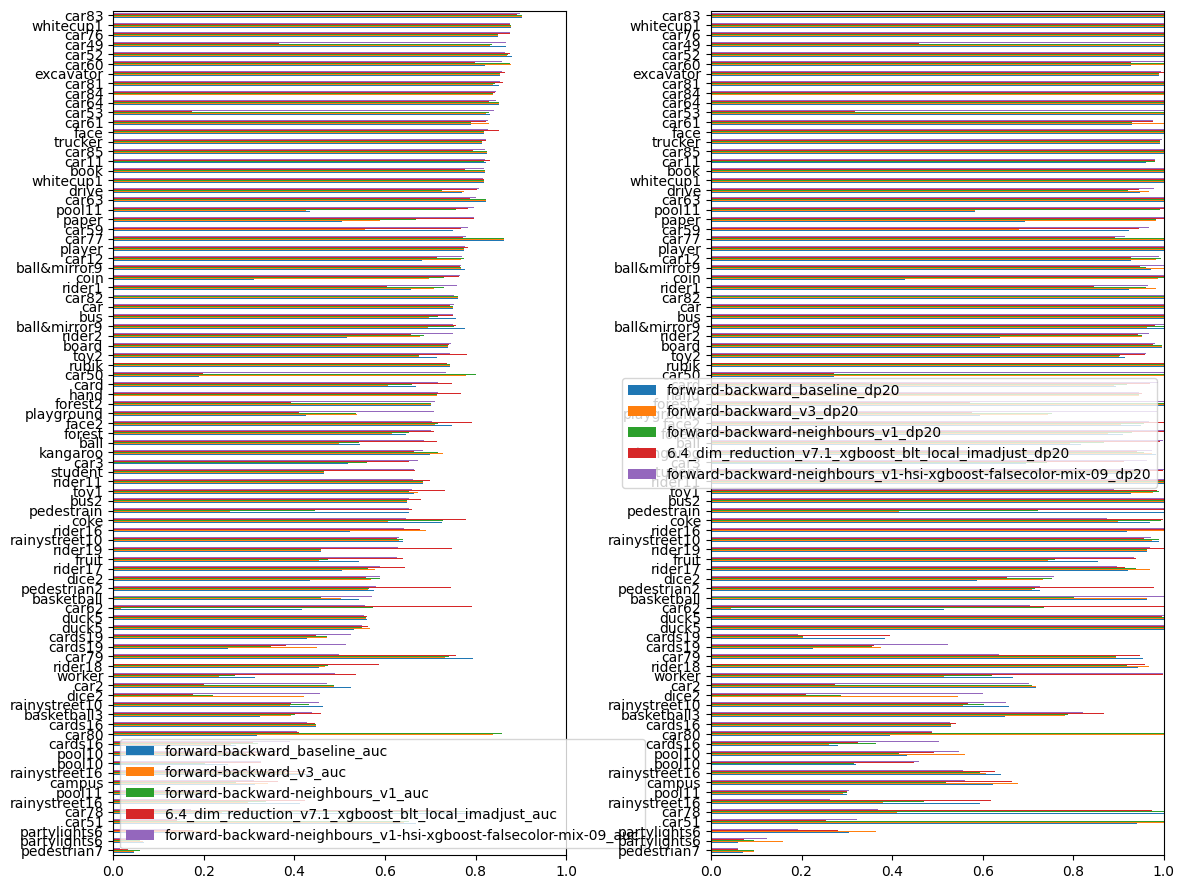

In [11]:
_, summary = eval_results_v2(
    val_dataset,
    [
        "forward-backward_baseline",
        "forward-backward_v3","forward-backward-neighbours_v1",
        # "forward-backward-neighbours_v1-hsi-xgboost",
        "6.4_dim_reduction_v7.1_xgboost_blt_local_imadjust",
        "forward-backward-neighbours_v1-hsi-xgboost-falsecolor-mix-09",
    ],
    plot=True,
)
#     sequence_ids=test_scenes)
display(summary)

In [12]:
print(summary.to_string())

metric                                                         model  mean AUC  mean DP20
2       forward-backward-neighbours_v1-hsi-xgboost-falsecolor-mix-09  0.634193   0.845616
1                                     forward-backward-neighbours_v1  0.627657   0.841613
0                  6.4_dim_reduction_v7.1_xgboost_blt_local_imadjust  0.620763   0.820088
4                                                forward-backward_v3  0.605431   0.820590
3                                          forward-backward_baseline  0.599976   0.805493
